In [6]:
import sys
import os.path as op
module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scipy.io import loadmat
import hypyp
import mne
import numpy as np

from data_analysis.functions_connectivity import \
    plot_connectivity_matrix
from data_analysis.functions_behavioral import \
    (create_event_df, remove_ghost_triggers, calculate_alpha,
     join_event_dfs, remove_outliers, events_from_event_df)

import matplotlib.pyplot as plt

result_dir = "/net/store/nbp/projects/hyperscanning/study_project/results/"

In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /net/store/nbp/projects/hyperscanning/study_project

In [2]:
subj = 206
cond = "early"
ispcs = loadmat(op.join(result_dir, "ispc_matrices", str(subj) + "_" + cond + ".mat"))[cond]

#mne.viz.plot_

In [3]:
ispcs[0, :, :, 0].shape

(128, 128)

In [4]:
tfr = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", str(subj) + "_" + cond))[0]

Reading /net/store/nbp/projects/hyperscanning/study_project/results/phase_angles/206_early ...


<ipython-input-4-f30baabdb29c>:1: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/study_project/results/phase_angles/206_early) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  tfr = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", str(subj) + "_" + cond))[0]


Not setting metadata


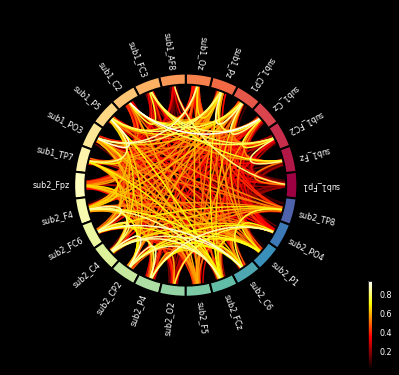

(<Figure size 576x576 with 2 Axes>, <PolarAxesSubplot:>)

In [5]:
mne.viz.plot_connectivity_circle(ispcs[0, ::5, ::5, 0], node_names=tfr.ch_names[::5])

In [6]:
avg_ispcs = np.mean(ispcs, axis=0)

/net/store/nbp/projects/hyperscanning/study_project/anne/NBP_Hyperscanning/data_analysis/functions_connectivity.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(reversed(node_names))
/net/store/nbp/projects/hyperscanning/study_project/anne/NBP_Hyperscanning/data_analysis/functions_connectivity.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(node_names)


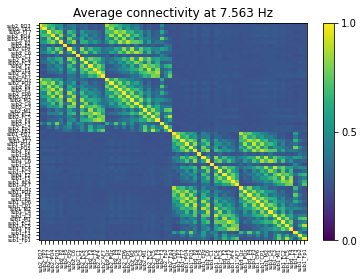

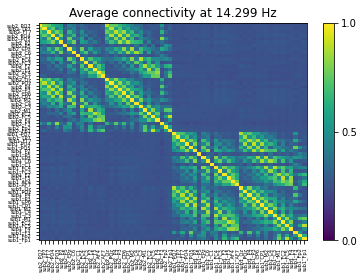

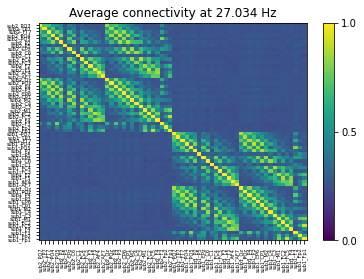

In [7]:
freq_i = 5
plot_connectivity_matrix(avg_ispcs[::2, ::2, freq_i], node_names=tfr.ch_names[::2],
                         title="Average connectivity at {} Hz".format(np.round(tfr.freqs[freq_i], 3)))

freq_i = 10
plot_connectivity_matrix(avg_ispcs[::2, ::2, freq_i], node_names=tfr.ch_names[::2],
                         title="Average connectivity at {} Hz".format(np.round(tfr.freqs[freq_i], 3)))

freq_i = 15
plot_connectivity_matrix(avg_ispcs[::2, ::2, freq_i], node_names=tfr.ch_names[::2],
                         title="Average connectivity at {} Hz".format(np.round(tfr.freqs[freq_i], 3)))

Intra vs Inter brain bar plots

In [8]:
inter_b = [np.mean(avg_ispcs[0:64, 64:2*64, i]) for i in range(len(tfr.freqs))]
intra_b = [np.mean(avg_ispcs[0:64, 0:64, i]) for i in range(len(tfr.freqs))]

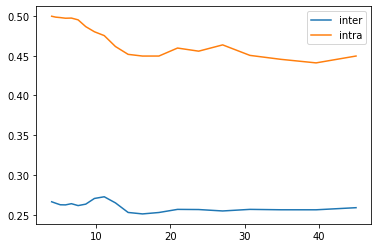

In [9]:
plt.plot(tfr.freqs, inter_b, tfr.freqs, intra_b)
plt.legend(["inter", "intra"])

#todo: bin frequencies and make a bar plot of data

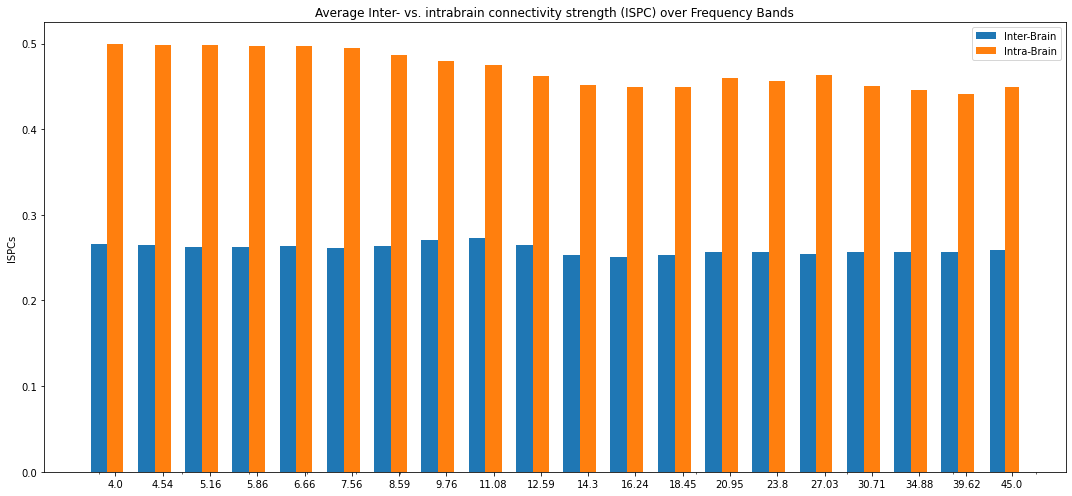

In [10]:
x = tfr.freqs  # the label locations
width = np.diff(x) # the width of the bars
width = np.append(width, [5.5], axis = 0) #needs to be added, otherwise width and x have different lengths
width /=3

fig, ax = plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, inter_b, width, label='Inter-Brain',align="edge")
rects2 = ax.bar(x + width/2, intra_b, width, label='Intra-Brain',align="edge")

labels = [str(round(i,2)) for i in tfr.freqs]

ax.set_ylabel('ISPCs')
ax.set_title('Average Inter- vs. intrabrain connectivity strength (ISPC) over Frequency Bands')
ax.set_xscale('log')
ax.set_xticks(x+width)
ax.set_xticklabels(labels)


ax.legend()

fig.tight_layout()

plt.show()

## load and plot the Small world indices

Text(0, 0.5, 'SWI')

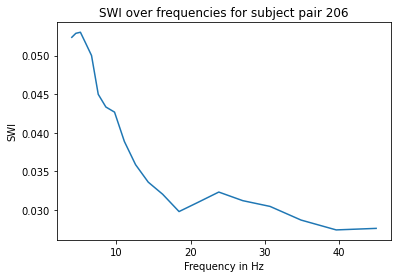

In [11]:
swis = loadmat(op.join(result_dir, "small_worlds", str(subj) + "_" + cond + ".mat"))[cond]

avg_swis = np.mean(swis, axis=0)

plt.plot(tfr.freqs, avg_swis)
plt.title("SWI over frequencies for subject pair {}".format(subj))
plt.xlabel("Frequency in Hz")
plt.ylabel("SWI")

## load the behavioral data and bad trials (which were filtered by autoreject)

In [12]:
import pandas


behav_path = "/net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/Behavioural_Analysis/BehaviouralData"

df = pandas.read_csv(op.join(behav_path, str(subj) + ".csv"))


In [13]:
# do the behavioral analysis and get the epochs
df = calculate_alpha(df)

In [14]:
# remove all the trials that were removed by autoreject
bad_trials = loadmat(op.join(result_dir, "dropped_epochs", str(subj) + ".mat"))
remove = list(bad_trials["drop_list"] +1)
df[np.logical_not(df["trial"].isin(remove))]
df

,pair,condition,block,trial,subject,tapnr,ttap,jitter,player_start_first,diff_inter,diff_intra,alpha,alpha_lin
0,206,blind,1,1,1,1,3.236128,0.075,1,-0.288034,0.829941,124.939269,124.939269
9,206,blind,1,1,2,1,3.524162,0.075,1,0.288034,0.567900,182.588901,177.411099
1,206,blind,1,1,1,2,4.066069,0.075,1,-0.025993,0.653433,14.320421,14.320421
10,206,blind,1,1,2,2,4.092062,0.075,1,0.025993,0.607567,15.401482,15.401482
2,206,blind,1,1,1,3,4.719502,0.075,1,0.019873,0.649501,11.014986,11.014986
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5397,206,blind,12,300,2,7,6.175468,0.050,2,-0.016368,0.361260,16.310827,16.310827
5389,206,blind,12,300,1,8,6.550315,0.050,2,0.013587,0.361834,13.518129,13.518129
5398,206,blind,12,300,2,8,6.536728,0.050,2,-0.013587,0.392970,12.447052,12.447052
5390,206,blind,12,300,1,9,6.912149,0.050,2,-0.017549,NaN,NaN,NaN


In [15]:
behavioral_df

# save time of first and last tap per trial in dataframe
first_tap = behavioral_df.index - behavioral_df.index[behavioral_df.index%9]
#behavioral_df["first_tap"] = behavioral_df["ttap"][first_tap].to_numpy()
#last_tap = behavioral_df.index - behavioral_df.index[(behavioral_df.index%9)] +8
#behavioral_df["last_tap"] = behavioral_df["ttap"][last_tap].to_numpy()

first_tap

NameError: name 'behavioral_df' is not defined

### Save all dropped data 

In [31]:
import pandas as pd
import os
import glob
import os.path as op


behav_res_path = "/net/store/nbp/projects/hyperscanning/study_project/anne/NBP_Hyperscanning/data_analysis/Behavioural_Analysis/BehaviouralData_Alphas/Trials_with_double_taps/"

In [32]:
# uncomment the following lines to save output as txt-file
#import sys 
#stdoutOrigin=sys.stdout 
#sys.stdout = open("Lost_data.txt", "w")

pair_list = pd.read_csv('pair_list.csv')

doubletap_trials_list = []
dropped_epochs_list = []
combined_list = []

for pair in list(pair_list.pair_name[6:]):
    print("Pair {}:".format(pair))
    df_doubletaps_trials = pd.read_csv(op.join(behav_res_path, str(pair) + "_lost_taps.csv"))
    print("Amount of lost trials due to double taps:",round(len(df_doubletaps_trials)/300*100,2),"%")

    bad_trials = loadmat(op.join(result_dir, "dropped_epochs", str(pair) + ".mat"))
    bad_trials = [item for sublist in bad_trials["drop_list"] for item in sublist]
    print("Amount of lost trials due to EEG cleaning:",round(len(bad_trials)/300*100,2),"%")

    combine_bads = list(bad_trials)
    combine_bads.extend(x for x in df_doubletaps_trials.trial if x not in combine_bads)
    print("Total amount of lost trials:",round(len(combine_bads)/300*100,2),"%", "\n")
    
    doubletap_trials_list.append(len(df_doubletaps_trials))
    dropped_epochs_list.append(len(bad_trials))
    combined_list.append(len(combine_bads))

Pair 202:
Amount of lost trials due to double taps: 6.0 %
Amount of lost trials due to EEG cleaning: 30.67 %
Total amount of lost trials: 35.33 % 

Pair 203:
Amount of lost trials due to double taps: 9.33 %
Amount of lost trials due to EEG cleaning: 51.33 %
Total amount of lost trials: 57.0 % 

Pair 204:
Amount of lost trials due to double taps: 11.33 %
Amount of lost trials due to EEG cleaning: 58.0 %
Total amount of lost trials: 61.67 % 

Pair 205:
Amount of lost trials due to double taps: 3.33 %
Amount of lost trials due to EEG cleaning: 83.33 %
Total amount of lost trials: 83.67 % 

Pair 206:
Amount of lost trials due to double taps: 10.67 %
Amount of lost trials due to EEG cleaning: 74.67 %
Total amount of lost trials: 75.33 % 

Pair 207:
Amount of lost trials due to double taps: 9.67 %
Amount of lost trials due to EEG cleaning: 83.0 %
Total amount of lost trials: 84.0 % 

Pair 208:
Amount of lost trials due to double taps: 18.67 %
Amount of lost trials due to EEG cleaning: 68.33 

In [34]:
columns = ["pair", "doubletap_trials", "dropped_epochs","combined"]
lost_data = pd.DataFrame(columns=columns)
lost_data.pair = list(pair_list.pair_name[6:])
lost_data.doubletap_trials = doubletap_trials_list
lost_data.dropped_epochs = dropped_epochs_list
lost_data.combined = combined_list

print("Total amount of lost trials due to double taps:",round(lost_data.mean().doubletap_trials/300*100,2),"%")
print("Total amount of lost trials due to EEG cleaning:",round(lost_data.mean().dropped_epochs/300*100,2),"%")
print("Total amount of lost trials (due to behavioural & neural cleaning):",round(lost_data.mean().combined/300*100,2),"%", "\n")

lost_data.to_csv("lost_data.csv")
# finish saving output as txt-file
#sys.stdout.close()
#sys.stdout=stdoutOrigin

Total amount of lost trials due to double taps: 13.4 %
Total amount of lost trials due to EEG cleaning: 60.03 %
Total amount of lost trials (due to behavioural & neural cleaning): 65.73 % 

